# Model

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

from acquire import get_total_sales_by_stores_data

import warnings
warnings.filterwarnings('ignore')

Using saas.csv or log data from API usage or store_item_sales

## Exercise 1
Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [2]:
def prep_saas():
    df = pd.read_csv('saas.csv')
    
    df.columns = [column.lower() for column in df]

    df['date'] = pd.to_datetime(df.month_invoiced)

    del df['month_invoiced']

    df = df.set_index('date').sort_index()
    
    df = df.resample('M').sum()

    return df

In [3]:
df = prep_saas()

In [4]:
df.shape

(48, 4)

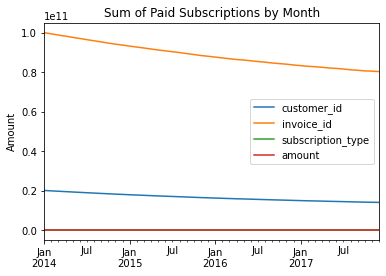

In [5]:
df.plot()
plt.title('Sum of Paid Subscriptions by Month')
plt.ylabel('Amount')
plt.xlabel('')
plt.show()

In [6]:
train_size = int(len(df) * .5)
train_size

24

In [7]:
validate_size = int(len(df) * .25)
validate_size

12

In [8]:
test_size = int(len(df) - train_size - validate_size)
test_size

12

In [9]:
validate_end_index = train_size + validate_size

In [10]:
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [11]:
print(len(train) + len(validate) + len(test) == len(df))

True


In [12]:
print(df.head(1) == train.head(1))

            customer_id  invoice_id  subscription_type  amount
date                                                          
2014-01-31         True        True               True    True


In [13]:
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,customer_id,invoice_id,subscription_type,amount
date,,,,
2016-12-31,15158997779,83812629131,10664.0,53320.0
2017-01-31,15061820113,83483733340,10679.0,53395.0


In [14]:
pd.concat([test.tail(1), df.tail(1)])

,customer_id,invoice_id,subscription_type,amount
date,,,,
2017-12-31,14148715257,80471625957,10761.0,53805.0
2017-12-31,14148715257,80471625957,10761.0,53805.0


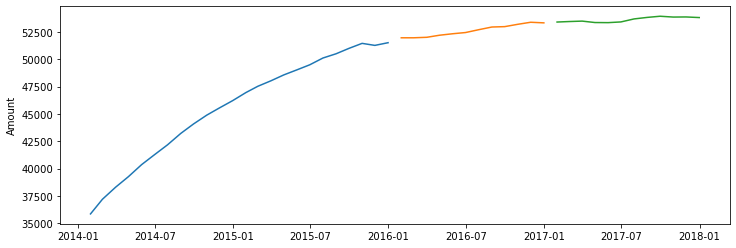

In [15]:
plt.figure(figsize=(12,4))
plt.plot(train.amount)
plt.plot(validate.amount)
plt.plot(test.amount)
plt.ylabel('Amount')
plt.show()

## Exercise 2
Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
- Simple Average
- Moving Average
- Holt's Linear Trend Model
- Based on previous year/month/etc., this is up to you.

In [16]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [17]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [18]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [19]:
eval_df

,model_type,target_var,rmse


### Simple Average

#### Make Predictions

In [20]:
amount = round(train['amount'].mean(),2)

In [21]:
amount

45568.54

In [22]:
yhat_df = pd.DataFrame({'amount':[amount]}, 
                       index = validate.index)

In [23]:
yhat_df

,amount
date,
2016-01-31,45568.54
2016-02-29,45568.54
2016-03-31,45568.54
2016-04-30,45568.54
2016-05-31,45568.54
2016-06-30,45568.54
2016-07-31,45568.54
2016-08-31,45568.54
2016-09-30,45568.54


#### Plot Actual vs. Predicted Values

amount -- RMSE: 7063


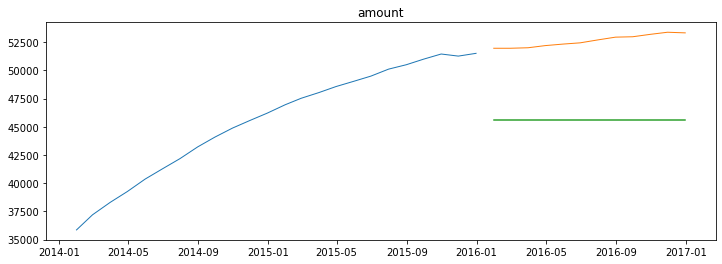

In [24]:
plot_and_eval('amount')

#### Evaluate

In [25]:
eval_df = append_eval_df(model_type = 'simple_average',
                            target_var = 'amount')

In [26]:
eval_df

,model_type,target_var,rmse
0,simple_average,amount,7063.0


### Moving Average

#### Make Predictions

In [27]:
period = 3
amount = round(train['amount'].rolling(period).mean()[-1],2)

In [28]:
amount

51403.33

In [29]:
yhat_df = pd.DataFrame({'amount':[amount]}, 
                       index = validate.index)

#### Plot Actual vs. Predicted Values

amount -- RMSE: 1315


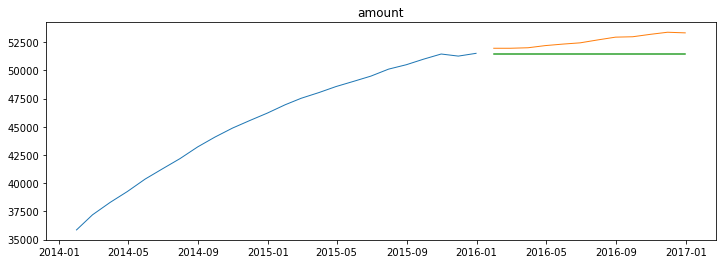

In [30]:
plot_and_eval('amount')

#### Evaluate

In [31]:
eval_df = append_eval_df(model_type = 'moving_average',
                            target_var = 'amount')

In [32]:
eval_df

,model_type,target_var,rmse
0,simple_average,amount,7063.0
1,moving_average,amount,1315.0


### Holt's Linear Trend

In [33]:
import statsmodels.api as sm

In [34]:
model = Holt(train['amount'], exponential = False)
model = model.fit(smoothing_level = 1, 
                  smoothing_slope = 1, 
                  optimized = True)
yhat_items = model.predict(start = validate.index[0], 
                           end = validate.index[-1])
yhat_df['amount'] = round(yhat_items, 2)

In [35]:
yhat_df.head()

,amount
date,
2016-01-31,51750.0
2016-02-29,51995.0
2016-03-31,52240.0
2016-04-30,52485.0
2016-05-31,52730.0


#### Plot Actual vs. Predicted Values

amount -- RMSE: 596


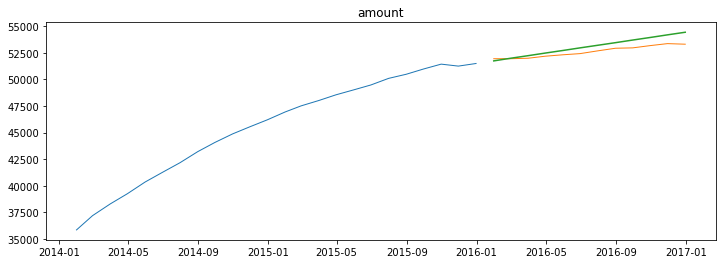

In [36]:
plot_and_eval('amount')

#### Evaluate

In [37]:
eval_df = append_eval_df(model_type = 'holts_average',
                            target_var = 'amount')

In [38]:
eval_df

,model_type,target_var,rmse
0,simple_average,amount,7063.0
1,moving_average,amount,1315.0
2,holts_average,amount,596.0


In [39]:
def plot_and_test(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.legend()
    plt.show()

In [40]:
yhat_df = validate + train.diff(12).mean()
yhat_df.index = test.index

In [41]:
yhat_df

,customer_id,invoice_id,subscription_type,amount
date,,,,
2017-01-31,1.442529e+10,8.160698e+10,12008.75,60043.75
2017-02-28,1.430317e+10,8.119546e+10,12008.75,60043.75
2017-03-31,1.417994e+10,8.077254e+10,12017.75,60088.75
2017-04-30,1.406283e+10,8.037669e+10,12055.75,60278.75
2017-05-31,1.397208e+10,8.011855e+10,12082.75,60413.75
2017-06-30,1.385890e+10,7.973449e+10,12104.75,60523.75
2017-07-31,1.374897e+10,7.936173e+10,12156.75,60783.75
2017-08-31,1.364490e+10,7.901716e+10,12205.75,61028.75
2017-09-30,1.353083e+10,7.861203e+10,12212.75,61063.75


In [42]:
rmse = round(sqrt(mean_squared_error(test['amount'],
                                    yhat_df['amount'])), 0)

In [43]:
print("rmse - amount_sold: ", rmse)

rmse - amount_sold:  7097.0


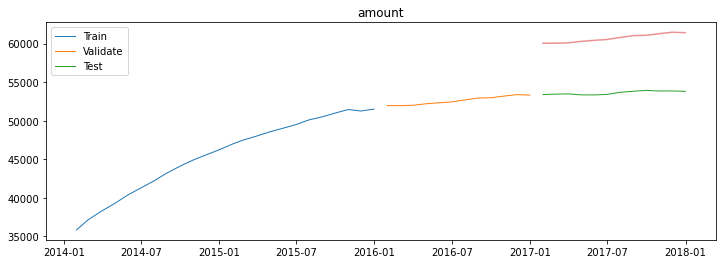

In [44]:
plot_and_test('amount')